In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns
plt.ion()   # interactive mode

Load Data
---------

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.


Its a cat bees dataset, constructing a transformation pipeline 


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



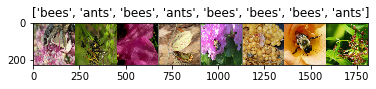

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Basic Training Function , the scheduler is lr=0.001, decays by 0.1 every 7 epochs

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs.size())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print('{} Rajat Best_Acc: {:.4f} Epoch_Acc: {:.4f}'.format(
                phase, best_acc, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            #collect losses
            if phase=='train':
                train_losses.append(epoch_loss)
            if phase=='val':
                val_losses.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_losses,val_losses

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print("modi",inputs.size())
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
import pandas as pd
def plot_losses(train_loss,val_loss):
    df = pd.DataFrame(list(zip([i for i in range(0,len(train_losses))],train_loss,val_loss)), 
               columns =['epoch', 'train_loss','val_loss']) 
    list_data=[df.train_loss,df.val_loss]
    plots=sns.lineplot(data=list_data)
    return plots

In [8]:
def dump_output(model,train_loss,val_loss,experiment_name):
    model_dump_path=experiment_name+'.pt'
    torch.save(model.state_dict(),model_dump_path)
    csv_dump_path=experiment_name+'.csv'
    df = pd.DataFrame(list(zip(train_loss,val_loss)), 
           columns =[ 'train_loss','val_loss'])
    df.to_csv(csv_dump_path)
    list_data=[df.train_loss,df.val_loss]
    plot_dump_path=experiment_name+'.png'
    plots=sns.lineplot(data=list_data)
    fig=plots.get_figure()
    fig.savefig(plot_dump_path)

E1. Train whole model, LR scheduler, 100 epochs, resnet18 
----------------------------------------------------------------------------
Resnet18, train the whole model

Best val Acc: 0.960784


In [9]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.6623 Acc: 0.5943
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5943
val Loss: 0.6035 Acc: 0.6732
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6732

Epoch 1/499
----------
train Loss: 0.6956 Acc: 0.5615
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5615
val Loss: 0.7599 Acc: 0.6732
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6732

Epoch 2/499
----------
train Loss: 0.7273 Acc: 0.6107
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6107
val Loss: 0.5916 Acc: 0.7059
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.7059

Epoch 3/499
----------
train Loss: 0.6264 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.7960 Acc: 0.5686
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.5686

Epoch 4/499
----------
train Loss: 0.6533 Acc: 0.6516
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6516
val Loss: 0.6177 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 5/499
----------
train Loss: 0.6195 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.5554 Ac

val Loss: 0.6311 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 47/499
----------
train Loss: 0.5678 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.6325 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 48/499
----------
train Loss: 0.5185 Acc: 0.7131
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7131
val Loss: 0.6170 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 49/499
----------
train Loss: 0.5514 Acc: 0.7172
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7172
val Loss: 0.6039 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 50/499
----------
train Loss: 0.5729 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.6484 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 51/499
----------
train Loss: 0.5477 Acc: 0.7172
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7172
val Loss: 0.6295 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 52/499
----------
train Loss: 0.54

train Loss: 0.5159 Acc: 0.7541
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7541
val Loss: 0.6024 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 94/499
----------
train Loss: 0.5665 Acc: 0.7295
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7295
val Loss: 0.5967 Acc: 0.6928
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6928

Epoch 95/499
----------
train Loss: 0.5239 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6062 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 96/499
----------
train Loss: 0.5645 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6233 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 97/499
----------
train Loss: 0.5527 Acc: 0.7049
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7049
val Loss: 0.6169 Acc: 0.6863
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6863

Epoch 98/499
----------
train Loss: 0.5393 Acc: 0.7377
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7377
val Loss: 0.5915 Acc: 0.6797
val Raja

val Loss: 0.6679 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 140/499
----------
train Loss: 0.5670 Acc: 0.7090
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7090
val Loss: 0.5952 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 141/499
----------
train Loss: 0.5536 Acc: 0.7131
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7131
val Loss: 0.6085 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 142/499
----------
train Loss: 0.5682 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6065 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 143/499
----------
train Loss: 0.5239 Acc: 0.7459
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7459
val Loss: 0.6322 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 144/499
----------
train Loss: 0.5606 Acc: 0.7090
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7090
val Loss: 0.6151 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 145/499
----------
train Loss

train Loss: 0.5227 Acc: 0.7418
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7418
val Loss: 0.6230 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 187/499
----------
train Loss: 0.5709 Acc: 0.7049
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7049
val Loss: 0.6215 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 188/499
----------
train Loss: 0.5505 Acc: 0.7254
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7254
val Loss: 0.6097 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 189/499
----------
train Loss: 0.5772 Acc: 0.7172
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7172
val Loss: 0.6187 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 190/499
----------
train Loss: 0.5341 Acc: 0.7377
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7377
val Loss: 0.6216 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 191/499
----------
train Loss: 0.5638 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.6356 Acc: 0.6471
val

val Loss: 0.6228 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 233/499
----------
train Loss: 0.5815 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.6326 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 234/499
----------
train Loss: 0.5331 Acc: 0.7418
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7418
val Loss: 0.6387 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 235/499
----------
train Loss: 0.5437 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.6228 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 236/499
----------
train Loss: 0.5494 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6148 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 237/499
----------
train Loss: 0.5406 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6247 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 238/499
----------
train Loss

train Loss: 0.5343 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.6095 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 280/499
----------
train Loss: 0.5294 Acc: 0.7336
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7336
val Loss: 0.6483 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 281/499
----------
train Loss: 0.5373 Acc: 0.7131
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7131
val Loss: 0.6225 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 282/499
----------
train Loss: 0.5611 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.6501 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 283/499
----------
train Loss: 0.5047 Acc: 0.7500
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7500
val Loss: 0.6319 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 284/499
----------
train Loss: 0.5267 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.6436 Acc: 0.6536
val

val Loss: 0.6189 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 326/499
----------
train Loss: 0.5184 Acc: 0.7254
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7254
val Loss: 0.6436 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 327/499
----------
train Loss: 0.5451 Acc: 0.6926
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6926
val Loss: 0.6214 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 328/499
----------
train Loss: 0.5101 Acc: 0.7623
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7623
val Loss: 0.6081 Acc: 0.6863
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6863

Epoch 329/499
----------
train Loss: 0.5464 Acc: 0.7254
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7254
val Loss: 0.6359 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 330/499
----------
train Loss: 0.5551 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.6042 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 331/499
----------
train Loss

train Loss: 0.5506 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6131 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 373/499
----------
train Loss: 0.5330 Acc: 0.6967
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6967
val Loss: 0.6084 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 374/499
----------
train Loss: 0.5514 Acc: 0.6967
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6967
val Loss: 0.6290 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 375/499
----------
train Loss: 0.5352 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.6003 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 376/499
----------
train Loss: 0.5327 Acc: 0.7295
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7295
val Loss: 0.6268 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 377/499
----------
train Loss: 0.5612 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.6128 Acc: 0.6797
val

val Loss: 0.6303 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 419/499
----------
train Loss: 0.5274 Acc: 0.7131
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7131
val Loss: 0.6311 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 420/499
----------
train Loss: 0.5650 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.5925 Acc: 0.6863
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6863

Epoch 421/499
----------
train Loss: 0.5388 Acc: 0.7377
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7377
val Loss: 0.6118 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 422/499
----------
train Loss: 0.5504 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.6171 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 423/499
----------
train Loss: 0.5395 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6091 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 424/499
----------
train Loss

train Loss: 0.5384 Acc: 0.7131
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7131
val Loss: 0.6347 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 466/499
----------
train Loss: 0.5011 Acc: 0.7541
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7541
val Loss: 0.6381 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 467/499
----------
train Loss: 0.5469 Acc: 0.6967
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6967
val Loss: 0.6392 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 468/499
----------
train Loss: 0.5459 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.6431 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 469/499
----------
train Loss: 0.5593 Acc: 0.7090
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7090
val Loss: 0.6145 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 470/499
----------
train Loss: 0.5550 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6327 Acc: 0.6667
val

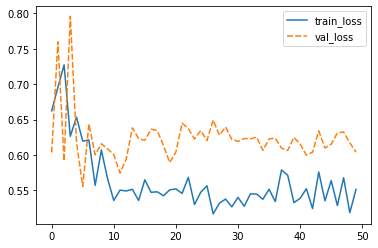

In [11]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet18_lrscheduler_wholenetwork')

E2)Train lastlayer, LR scheduler, 100 epochs, resnet18 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248


In [12]:
model_conv = torchvision.models.resnet18(pretrained=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv.fc

Linear(in_features=512, out_features=2, bias=True)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.5934 Acc: 0.6885
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6885


/home/bashturtle/anaconda3/envs/gpuenv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.5887 Acc: 0.6797
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6797

Epoch 1/499
----------
train Loss: 0.6134 Acc: 0.6352
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6352
val Loss: 0.5873 Acc: 0.6863
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6863

Epoch 2/499
----------
train Loss: 0.5925 Acc: 0.6967
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6967
val Loss: 0.5925 Acc: 0.6928
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6928

Epoch 3/499
----------
train Loss: 0.5995 Acc: 0.6762
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6762
val Loss: 0.5852 Acc: 0.6928
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6928

Epoch 4/499
----------
train Loss: 0.5977 Acc: 0.7008
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7008
val Loss: 0.5997 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 5/499
----------
train Loss: 0.5919 Acc: 0.6885
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6885
val Loss: 0.5919 Acc: 0.6928
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6928

Epoch 6/499
----------
train Loss: 0.6013 Acc

train Loss: 0.5948 Acc: 0.7213
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7213
val Loss: 0.5904 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 48/499
----------
train Loss: 0.5941 Acc: 0.6967
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6967
val Loss: 0.5968 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 49/499
----------
train Loss: 0.6090 Acc: 0.6516
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6516
val Loss: 0.5907 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 50/499
----------
train Loss: 0.5893 Acc: 0.7131
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7131
val Loss: 0.5935 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 51/499
----------
train Loss: 0.5996 Acc: 0.7090
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7090
val Loss: 0.5988 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 52/499
----------
train Loss: 0.6087 Acc: 0.6639
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6639
val Loss: 0.5883 Acc: 0.6863
val Raja

val Loss: 0.5999 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 94/499
----------
train Loss: 0.6076 Acc: 0.6598
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6598
val Loss: 0.5899 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 95/499
----------
train Loss: 0.5957 Acc: 0.6885
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6885
val Loss: 0.5965 Acc: 0.6601
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6601

Epoch 96/499
----------
train Loss: 0.5903 Acc: 0.7008
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7008
val Loss: 0.5929 Acc: 0.7059
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7059

Epoch 97/499
----------
train Loss: 0.6036 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.5900 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 98/499
----------
train Loss: 0.6154 Acc: 0.6557
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6557
val Loss: 0.5890 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 99/499
----------
train Loss: 0.60

train Loss: 0.5897 Acc: 0.7418
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7418
val Loss: 0.5947 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 141/499
----------
train Loss: 0.5792 Acc: 0.7090
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7090
val Loss: 0.5946 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 142/499
----------
train Loss: 0.5957 Acc: 0.6557
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6557
val Loss: 0.6019 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 143/499
----------
train Loss: 0.5867 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.5864 Acc: 0.7059
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7059

Epoch 144/499
----------
train Loss: 0.6004 Acc: 0.6803
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6803
val Loss: 0.5961 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 145/499
----------
train Loss: 0.5864 Acc: 0.7049
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7049
val Loss: 0.5930 Acc: 0.6732
val

val Loss: 0.5874 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 187/499
----------
train Loss: 0.6079 Acc: 0.6721
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6721
val Loss: 0.5992 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 188/499
----------
train Loss: 0.5879 Acc: 0.7213
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7213
val Loss: 0.5874 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 189/499
----------
train Loss: 0.6051 Acc: 0.6598
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6598
val Loss: 0.5930 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 190/499
----------
train Loss: 0.5908 Acc: 0.7172
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7172
val Loss: 0.5969 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 191/499
----------
train Loss: 0.6174 Acc: 0.6475
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6475
val Loss: 0.6005 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 192/499
----------
train Loss

train Loss: 0.6068 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.5838 Acc: 0.7059
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7059

Epoch 234/499
----------
train Loss: 0.5833 Acc: 0.7008
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7008
val Loss: 0.5946 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 235/499
----------
train Loss: 0.6230 Acc: 0.6516
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6516
val Loss: 0.5915 Acc: 0.6471
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6471

Epoch 236/499
----------
train Loss: 0.5981 Acc: 0.6680
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6680
val Loss: 0.5925 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 237/499
----------
train Loss: 0.5979 Acc: 0.7008
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7008
val Loss: 0.5905 Acc: 0.6601
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6601

Epoch 238/499
----------
train Loss: 0.6043 Acc: 0.6598
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6598
val Loss: 0.5878 Acc: 0.6863
val

val Loss: 0.5840 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 280/499
----------
train Loss: 0.5799 Acc: 0.7172
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7172
val Loss: 0.5854 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 281/499
----------
train Loss: 0.6017 Acc: 0.6598
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6598
val Loss: 0.5956 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 282/499
----------
train Loss: 0.6113 Acc: 0.6762
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6762
val Loss: 0.5847 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 283/499
----------
train Loss: 0.5836 Acc: 0.7213
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7213
val Loss: 0.5924 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 284/499
----------
train Loss: 0.6099 Acc: 0.6639
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6639
val Loss: 0.5971 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 285/499
----------
train Loss

train Loss: 0.5958 Acc: 0.7008
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7008
val Loss: 0.5914 Acc: 0.7124
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7124

Epoch 327/499
----------
train Loss: 0.5999 Acc: 0.6557
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6557
val Loss: 0.5920 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 328/499
----------
train Loss: 0.5945 Acc: 0.6967
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6967
val Loss: 0.5925 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 329/499
----------
train Loss: 0.5952 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.5933 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 330/499
----------
train Loss: 0.5806 Acc: 0.7377
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7377
val Loss: 0.6000 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 331/499
----------
train Loss: 0.5934 Acc: 0.6557
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6557
val Loss: 0.5961 Acc: 0.6536
val

val Loss: 0.5942 Acc: 0.7124
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7124

Epoch 373/499
----------
train Loss: 0.6146 Acc: 0.6393
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6393
val Loss: 0.5942 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 374/499
----------
train Loss: 0.5919 Acc: 0.7049
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7049
val Loss: 0.5882 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 375/499
----------
train Loss: 0.5822 Acc: 0.7090
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7090
val Loss: 0.5941 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 376/499
----------
train Loss: 0.5970 Acc: 0.6434
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6434
val Loss: 0.5906 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 377/499
----------
train Loss: 0.6021 Acc: 0.6721
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6721
val Loss: 0.5930 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 378/499
----------
train Loss

train Loss: 0.6058 Acc: 0.6516
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6516
val Loss: 0.5946 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 420/499
----------
train Loss: 0.6022 Acc: 0.6680
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6680
val Loss: 0.5935 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 421/499
----------
train Loss: 0.6045 Acc: 0.6680
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6680
val Loss: 0.5929 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 422/499
----------
train Loss: 0.5974 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.6036 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 423/499
----------
train Loss: 0.5970 Acc: 0.6680
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6680
val Loss: 0.5867 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 424/499
----------
train Loss: 0.5982 Acc: 0.6885
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6885
val Loss: 0.5887 Acc: 0.6797
val

val Loss: 0.5845 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 466/499
----------
train Loss: 0.5787 Acc: 0.7172
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7172
val Loss: 0.6016 Acc: 0.7059
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7059

Epoch 467/499
----------
train Loss: 0.6079 Acc: 0.6639
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6639
val Loss: 0.5891 Acc: 0.6993
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6993

Epoch 468/499
----------
train Loss: 0.5872 Acc: 0.7254
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.7254
val Loss: 0.5941 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 469/499
----------
train Loss: 0.5941 Acc: 0.6967
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6967
val Loss: 0.5893 Acc: 0.6928
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6928

Epoch 470/499
----------
train Loss: 0.6092 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.5919 Acc: 0.6863
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6863

Epoch 471/499
----------
train Loss

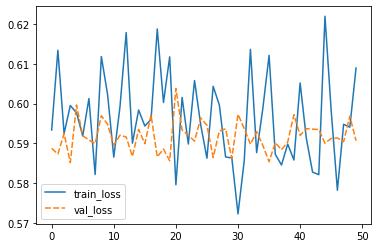

In [15]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet18_lrscheduler_lastlayer')

E3)Train wholenetwork, LR scheduler, 1000 epochs, resnet34 
----------------------------------

Resnet34, train the whole network




In [16]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.7690 Acc: 0.5369
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5369
val Loss: 0.8167 Acc: 0.6144
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6144

Epoch 1/499
----------
train Loss: 0.7198 Acc: 0.5574
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5574
val Loss: 0.6808 Acc: 0.6340
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.6340

Epoch 2/499
----------
train Loss: 0.8003 Acc: 0.5697
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5697
val Loss: 1.1544 Acc: 0.5425
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5425

Epoch 3/499
----------
train Loss: 0.8059 Acc: 0.5820
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5820
val Loss: 0.7029 Acc: 0.6667
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6667

Epoch 4/499
----------
train Loss: 0.6406 Acc: 0.6107
train Rajat Best_Acc: 0.6667 Epoch_Acc: 0.6107
val Loss: 0.7319 Acc: 0.6797
val Rajat Best_Acc: 0.6667 Epoch_Acc: 0.6797

Epoch 5/499
----------
train Loss: 0.6609 Acc: 0.6844
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6844
val Loss: 0.8907 Ac

val Loss: 0.5961 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 47/499
----------
train Loss: 0.5674 Acc: 0.6967
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6967
val Loss: 0.6209 Acc: 0.6928
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6928

Epoch 48/499
----------
train Loss: 0.5621 Acc: 0.6885
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6885
val Loss: 0.6018 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 49/499
----------
train Loss: 0.5581 Acc: 0.7049
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7049
val Loss: 0.5911 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 50/499
----------
train Loss: 0.5868 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.6039 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 51/499
----------
train Loss: 0.5569 Acc: 0.6639
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6639
val Loss: 0.6096 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 52/499
----------
train Loss: 0.59

train Loss: 0.5798 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.5933 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 94/499
----------
train Loss: 0.5381 Acc: 0.7418
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7418
val Loss: 0.5999 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 95/499
----------
train Loss: 0.5692 Acc: 0.7049
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7049
val Loss: 0.6019 Acc: 0.6863
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6863

Epoch 96/499
----------
train Loss: 0.5400 Acc: 0.7172
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7172
val Loss: 0.5932 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 97/499
----------
train Loss: 0.5604 Acc: 0.7172
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7172
val Loss: 0.6016 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 98/499
----------
train Loss: 0.5519 Acc: 0.7172
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7172
val Loss: 0.6139 Acc: 0.6863
val Raja

val Loss: 0.6058 Acc: 0.6601
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6601

Epoch 140/499
----------
train Loss: 0.5308 Acc: 0.7664
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7664
val Loss: 0.5996 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 141/499
----------
train Loss: 0.5744 Acc: 0.6885
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6885
val Loss: 0.6044 Acc: 0.6928
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6928

Epoch 142/499
----------
train Loss: 0.5489 Acc: 0.7090
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7090
val Loss: 0.5980 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 143/499
----------
train Loss: 0.5729 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.6059 Acc: 0.6536
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6536

Epoch 144/499
----------
train Loss: 0.5318 Acc: 0.7131
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7131
val Loss: 0.5948 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 145/499
----------
train Loss

train Loss: 0.5470 Acc: 0.6926
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6926
val Loss: 0.6127 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 187/499
----------
train Loss: 0.5548 Acc: 0.7172
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7172
val Loss: 0.5987 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 188/499
----------
train Loss: 0.5680 Acc: 0.6721
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6721
val Loss: 0.5879 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 189/499
----------
train Loss: 0.5816 Acc: 0.6434
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6434
val Loss: 0.6219 Acc: 0.6928
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6928

Epoch 190/499
----------
train Loss: 0.5171 Acc: 0.7582
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7582
val Loss: 0.6098 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 191/499
----------
train Loss: 0.5634 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.5940 Acc: 0.6601
val

val Loss: 0.5873 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 233/499
----------
train Loss: 0.5502 Acc: 0.7090
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7090
val Loss: 0.5929 Acc: 0.6601
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6601

Epoch 234/499
----------
train Loss: 0.5476 Acc: 0.7131
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7131
val Loss: 0.5894 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 235/499
----------
train Loss: 0.5776 Acc: 0.6885
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6885
val Loss: 0.6331 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 236/499
----------
train Loss: 0.5505 Acc: 0.7090
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7090
val Loss: 0.6049 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 237/499
----------
train Loss: 0.5334 Acc: 0.7254
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7254
val Loss: 0.6009 Acc: 0.6601
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6601

Epoch 238/499
----------
train Loss

train Loss: 0.5793 Acc: 0.6762
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6762
val Loss: 0.6083 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 280/499
----------
train Loss: 0.5633 Acc: 0.7172
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7172
val Loss: 0.6170 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 281/499
----------
train Loss: 0.5532 Acc: 0.7090
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7090
val Loss: 0.5928 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 282/499
----------
train Loss: 0.5711 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.5954 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 283/499
----------
train Loss: 0.5413 Acc: 0.7213
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7213
val Loss: 0.6015 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 284/499
----------
train Loss: 0.5889 Acc: 0.6680
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6680
val Loss: 0.5888 Acc: 0.6601
val

val Loss: 0.6072 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 326/499
----------
train Loss: 0.5556 Acc: 0.7008
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7008
val Loss: 0.6048 Acc: 0.6863
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6863

Epoch 327/499
----------
train Loss: 0.5969 Acc: 0.6680
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6680
val Loss: 0.6046 Acc: 0.6601
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6601

Epoch 328/499
----------
train Loss: 0.5543 Acc: 0.7090
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7090
val Loss: 0.6070 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 329/499
----------
train Loss: 0.5245 Acc: 0.7131
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7131
val Loss: 0.5952 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 330/499
----------
train Loss: 0.5885 Acc: 0.6598
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6598
val Loss: 0.5950 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 331/499
----------
train Loss

train Loss: 0.5870 Acc: 0.6885
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6885
val Loss: 0.5927 Acc: 0.6928
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6928

Epoch 373/499
----------
train Loss: 0.5819 Acc: 0.6393
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6393
val Loss: 0.6041 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 374/499
----------
train Loss: 0.5555 Acc: 0.7008
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7008
val Loss: 0.6062 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 375/499
----------
train Loss: 0.5556 Acc: 0.7295
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7295
val Loss: 0.6033 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 376/499
----------
train Loss: 0.5484 Acc: 0.7336
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7336
val Loss: 0.6069 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 377/499
----------
train Loss: 0.5615 Acc: 0.7131
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7131
val Loss: 0.5974 Acc: 0.6601
val

val Loss: 0.6107 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 419/499
----------
train Loss: 0.5462 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.5967 Acc: 0.6601
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6601

Epoch 420/499
----------
train Loss: 0.5709 Acc: 0.7008
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7008
val Loss: 0.6071 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 421/499
----------
train Loss: 0.5346 Acc: 0.7418
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7418
val Loss: 0.5952 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 422/499
----------
train Loss: 0.5679 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.6040 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 423/499
----------
train Loss: 0.5528 Acc: 0.7213
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7213
val Loss: 0.5961 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 424/499
----------
train Loss

train Loss: 0.5444 Acc: 0.7418
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7418
val Loss: 0.6026 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 466/499
----------
train Loss: 0.5443 Acc: 0.6844
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6844
val Loss: 0.6016 Acc: 0.6797
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6797

Epoch 467/499
----------
train Loss: 0.5563 Acc: 0.6967
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6967
val Loss: 0.5960 Acc: 0.6667
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6667

Epoch 468/499
----------
train Loss: 0.5500 Acc: 0.7131
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.7131
val Loss: 0.6006 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 469/499
----------
train Loss: 0.6330 Acc: 0.6230
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6230
val Loss: 0.6133 Acc: 0.6732
val Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6732

Epoch 470/499
----------
train Loss: 0.5632 Acc: 0.6885
train Rajat Best_Acc: 0.7255 Epoch_Acc: 0.6885
val Loss: 0.5869 Acc: 0.6797
val

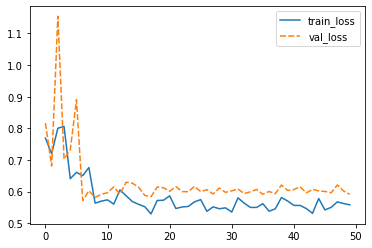

In [17]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet34_lrscheduler_wholenetwork')

E4)Train lastlayer, LR scheduler, 100 epochs, resnet34 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248


In [18]:
model_conv = torchvision.models.resnet34(pretrained=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.6079 Acc: 0.6803
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6803
val Loss: 0.6123 Acc: 0.6601
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6601

Epoch 1/499
----------
train Loss: 0.6128 Acc: 0.6803
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6803
val Loss: 0.6193 Acc: 0.6601
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6601

Epoch 2/499
----------
train Loss: 0.6308 Acc: 0.6516
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6516
val Loss: 0.6585 Acc: 0.6536
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6536

Epoch 3/499
----------
train Loss: 0.5879 Acc: 0.6926
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6926
val Loss: 0.6487 Acc: 0.6405
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6405

Epoch 4/499
----------
train Loss: 0.6014 Acc: 0.6680
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6680
val Loss: 0.6140 Acc: 0.6601
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6601

Epoch 5/499
----------
train Loss: 0.6805 Acc: 0.6270
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6270
val Loss: 0.6261 Ac

val Loss: 0.6432 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 47/499
----------
train Loss: 0.6325 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6281 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 48/499
----------
train Loss: 0.6551 Acc: 0.6516
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6516
val Loss: 0.6415 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 49/499
----------
train Loss: 0.5642 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6665 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 50/499
----------
train Loss: 0.6182 Acc: 0.6557
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6557
val Loss: 0.6305 Acc: 0.6667
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6667

Epoch 51/499
----------
train Loss: 0.6350 Acc: 0.6434
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6434
val Loss: 0.6301 Acc: 0.6667
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6667

Epoch 52/499
----------
train Loss: 0.61

train Loss: 0.5959 Acc: 0.6762
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6762
val Loss: 0.6423 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 94/499
----------
train Loss: 0.5913 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6331 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 95/499
----------
train Loss: 0.6069 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6350 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 96/499
----------
train Loss: 0.6373 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6129 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 97/499
----------
train Loss: 0.5918 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6146 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 98/499
----------
train Loss: 0.5815 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6153 Acc: 0.6601
val Raja

val Loss: 0.6386 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 140/499
----------
train Loss: 0.5776 Acc: 0.7131
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7131
val Loss: 0.6447 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 141/499
----------
train Loss: 0.6091 Acc: 0.6844
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6844
val Loss: 0.6059 Acc: 0.6732
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6732

Epoch 142/499
----------
train Loss: 0.6054 Acc: 0.7008
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7008
val Loss: 0.6329 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 143/499
----------
train Loss: 0.5953 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6526 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 144/499
----------
train Loss: 0.5816 Acc: 0.7131
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7131
val Loss: 0.6113 Acc: 0.6732
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6732

Epoch 145/499
----------
train Loss

train Loss: 0.6594 Acc: 0.6803
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6803
val Loss: 0.6199 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 187/499
----------
train Loss: 0.6303 Acc: 0.6516
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6516
val Loss: 0.5930 Acc: 0.7059
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7059

Epoch 188/499
----------
train Loss: 0.5911 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6198 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 189/499
----------
train Loss: 0.5787 Acc: 0.6967
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6967
val Loss: 0.6152 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 190/499
----------
train Loss: 0.5771 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6181 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 191/499
----------
train Loss: 0.6097 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.6239 Acc: 0.6601
val

val Loss: 0.6091 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 233/499
----------
train Loss: 0.6297 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.6254 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 234/499
----------
train Loss: 0.6058 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.6537 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 235/499
----------
train Loss: 0.5852 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.6523 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 236/499
----------
train Loss: 0.6013 Acc: 0.6926
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6926
val Loss: 0.6342 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 237/499
----------
train Loss: 0.6708 Acc: 0.6189
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6189
val Loss: 0.6124 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 238/499
----------
train Loss

train Loss: 0.6393 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.6132 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 280/499
----------
train Loss: 0.6201 Acc: 0.6475
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6475
val Loss: 0.6278 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 281/499
----------
train Loss: 0.5779 Acc: 0.6721
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6721
val Loss: 0.6020 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 282/499
----------
train Loss: 0.6272 Acc: 0.6598
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6598
val Loss: 0.6238 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 283/499
----------
train Loss: 0.6132 Acc: 0.6926
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6926
val Loss: 0.6388 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 284/499
----------
train Loss: 0.6008 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.6192 Acc: 0.6536
val

val Loss: 0.6139 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 326/499
----------
train Loss: 0.6283 Acc: 0.6721
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6721
val Loss: 0.6123 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 327/499
----------
train Loss: 0.5953 Acc: 0.6803
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6803
val Loss: 0.6345 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 328/499
----------
train Loss: 0.6048 Acc: 0.6721
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6721
val Loss: 0.6202 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 329/499
----------
train Loss: 0.6096 Acc: 0.6598
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6598
val Loss: 0.6387 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 330/499
----------
train Loss: 0.6155 Acc: 0.6803
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6803
val Loss: 0.6196 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 331/499
----------
train Loss

train Loss: 0.5966 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.5975 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 373/499
----------
train Loss: 0.6413 Acc: 0.6516
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6516
val Loss: 0.6651 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 374/499
----------
train Loss: 0.5960 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.6362 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 375/499
----------
train Loss: 0.6553 Acc: 0.5984
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.5984
val Loss: 0.6357 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 376/499
----------
train Loss: 0.5939 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.6138 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 377/499
----------
train Loss: 0.6063 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.6047 Acc: 0.6732
val

val Loss: 0.6284 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 419/499
----------
train Loss: 0.6522 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6246 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 420/499
----------
train Loss: 0.6872 Acc: 0.6434
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6434
val Loss: 0.6557 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 421/499
----------
train Loss: 0.6336 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6103 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 422/499
----------
train Loss: 0.6077 Acc: 0.6926
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6926
val Loss: 0.6600 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 423/499
----------
train Loss: 0.5572 Acc: 0.7336
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7336
val Loss: 0.6791 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 424/499
----------
train Loss

train Loss: 0.6270 Acc: 0.6516
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6516
val Loss: 0.6364 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 466/499
----------
train Loss: 0.5901 Acc: 0.7008
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7008
val Loss: 0.6213 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 467/499
----------
train Loss: 0.6077 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.6757 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 468/499
----------
train Loss: 0.6087 Acc: 0.6803
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6803
val Loss: 0.6025 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 469/499
----------
train Loss: 0.6075 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.6310 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 470/499
----------
train Loss: 0.6626 Acc: 0.6352
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6352
val Loss: 0.6179 Acc: 0.6601
val

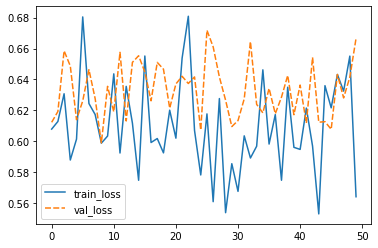

In [19]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet34_lrscheduler_lastlayer')

E5)Train wholenetwork, LR scheduler, 500 epochs, resnet50 
----------------------------------

Resnet50, train the whole network




In [20]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 1.2014 Acc: 0.5123
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5123
val Loss: 3.3071 Acc: 0.5948
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5948

Epoch 1/499
----------
train Loss: 0.9335 Acc: 0.4836
train Rajat Best_Acc: 0.5948 Epoch_Acc: 0.4836
val Loss: 3.2827 Acc: 0.6144
val Rajat Best_Acc: 0.5948 Epoch_Acc: 0.6144

Epoch 2/499
----------
train Loss: 1.1682 Acc: 0.5041
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5041
val Loss: 3.2708 Acc: 0.5425
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5425

Epoch 3/499
----------
train Loss: 1.7063 Acc: 0.5369
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5369
val Loss: 1.4025 Acc: 0.5229
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5229

Epoch 4/499
----------
train Loss: 0.7706 Acc: 0.5738
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5738
val Loss: 3.4352 Acc: 0.4575
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.4575

Epoch 5/499
----------
train Loss: 1.0429 Acc: 0.5328
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5328
val Loss: 1.3692 Ac

val Loss: 0.6417 Acc: 0.6078
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6078

Epoch 47/499
----------
train Loss: 0.5887 Acc: 0.7008
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7008
val Loss: 0.6294 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 48/499
----------
train Loss: 0.5947 Acc: 0.6352
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6352
val Loss: 0.6568 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 49/499
----------
train Loss: 0.5919 Acc: 0.6475
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6475
val Loss: 0.6549 Acc: 0.6078
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6078

Epoch 50/499
----------
train Loss: 0.6027 Acc: 0.6516
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6516
val Loss: 0.6551 Acc: 0.6275
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6275

Epoch 51/499
----------
train Loss: 0.5965 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6360 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 52/499
----------
train Loss: 0.57

train Loss: 0.6113 Acc: 0.6352
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6352
val Loss: 0.6514 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 94/499
----------
train Loss: 0.6038 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6346 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 95/499
----------
train Loss: 0.5911 Acc: 0.6762
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6762
val Loss: 0.6382 Acc: 0.6275
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6275

Epoch 96/499
----------
train Loss: 0.5891 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6604 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 97/499
----------
train Loss: 0.5793 Acc: 0.7131
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7131
val Loss: 0.6596 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 98/499
----------
train Loss: 0.5878 Acc: 0.6885
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6885
val Loss: 0.6450 Acc: 0.6078
val Raja

val Loss: 0.6305 Acc: 0.6078
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6078

Epoch 140/499
----------
train Loss: 0.5718 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6236 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 141/499
----------
train Loss: 0.5921 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6311 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 142/499
----------
train Loss: 0.6017 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6479 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 143/499
----------
train Loss: 0.6014 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6537 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 144/499
----------
train Loss: 0.6293 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6449 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 145/499
----------
train Loss

train Loss: 0.5941 Acc: 0.7008
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7008
val Loss: 0.6379 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 187/499
----------
train Loss: 0.5975 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6377 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 188/499
----------
train Loss: 0.5854 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6585 Acc: 0.6013
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6013

Epoch 189/499
----------
train Loss: 0.5952 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6432 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 190/499
----------
train Loss: 0.6006 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6376 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 191/499
----------
train Loss: 0.5998 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6372 Acc: 0.6078
val

val Loss: 0.6412 Acc: 0.6013
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6013

Epoch 233/499
----------
train Loss: 0.5663 Acc: 0.6844
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6844
val Loss: 0.6519 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 234/499
----------
train Loss: 0.6026 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6435 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 235/499
----------
train Loss: 0.5841 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6316 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 236/499
----------
train Loss: 0.5958 Acc: 0.6803
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6803
val Loss: 0.6488 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 237/499
----------
train Loss: 0.6026 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6429 Acc: 0.6275
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6275

Epoch 238/499
----------
train Loss

train Loss: 0.5848 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6554 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 280/499
----------
train Loss: 0.5865 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6360 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 281/499
----------
train Loss: 0.5888 Acc: 0.7090
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7090
val Loss: 0.6469 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 282/499
----------
train Loss: 0.5823 Acc: 0.6803
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6803
val Loss: 0.6420 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 283/499
----------
train Loss: 0.5928 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6413 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 284/499
----------
train Loss: 0.5908 Acc: 0.7131
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7131
val Loss: 0.6264 Acc: 0.6601
val

val Loss: 0.6338 Acc: 0.6471
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6471

Epoch 326/499
----------
train Loss: 0.6172 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6469 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 327/499
----------
train Loss: 0.5939 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6467 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 328/499
----------
train Loss: 0.6003 Acc: 0.6598
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6598
val Loss: 0.6420 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 329/499
----------
train Loss: 0.6043 Acc: 0.6639
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6639
val Loss: 0.6411 Acc: 0.6013
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6013

Epoch 330/499
----------
train Loss: 0.6101 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6470 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 331/499
----------
train Loss

train Loss: 0.6339 Acc: 0.6311
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6311
val Loss: 0.6369 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 373/499
----------
train Loss: 0.5985 Acc: 0.7131
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7131
val Loss: 0.6434 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 374/499
----------
train Loss: 0.6020 Acc: 0.6721
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6721
val Loss: 0.6470 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 375/499
----------
train Loss: 0.6109 Acc: 0.6762
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6762
val Loss: 0.6388 Acc: 0.6275
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6275

Epoch 376/499
----------
train Loss: 0.5826 Acc: 0.6967
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6967
val Loss: 0.6385 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 377/499
----------
train Loss: 0.6032 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6601 Acc: 0.6144
val

val Loss: 0.6612 Acc: 0.6013
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6013

Epoch 419/499
----------
train Loss: 0.6129 Acc: 0.6434
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6434
val Loss: 0.6364 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 420/499
----------
train Loss: 0.6035 Acc: 0.6721
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6721
val Loss: 0.6491 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 421/499
----------
train Loss: 0.5842 Acc: 0.7049
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7049
val Loss: 0.6529 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 422/499
----------
train Loss: 0.6283 Acc: 0.6434
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6434
val Loss: 0.6532 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 423/499
----------
train Loss: 0.5886 Acc: 0.7090
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7090
val Loss: 0.6383 Acc: 0.6209
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6209

Epoch 424/499
----------
train Loss

train Loss: 0.5961 Acc: 0.7172
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.7172
val Loss: 0.6267 Acc: 0.6536
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6536

Epoch 466/499
----------
train Loss: 0.5915 Acc: 0.6762
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6762
val Loss: 0.6564 Acc: 0.6405
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6405

Epoch 467/499
----------
train Loss: 0.6100 Acc: 0.6926
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6926
val Loss: 0.6404 Acc: 0.6601
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6601

Epoch 468/499
----------
train Loss: 0.5844 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6692 Acc: 0.6340
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6340

Epoch 469/499
----------
train Loss: 0.5987 Acc: 0.6680
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6680
val Loss: 0.6807 Acc: 0.6144
val Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6144

Epoch 470/499
----------
train Loss: 0.5990 Acc: 0.6844
train Rajat Best_Acc: 0.6928 Epoch_Acc: 0.6844
val Loss: 0.6339 Acc: 0.6078
val

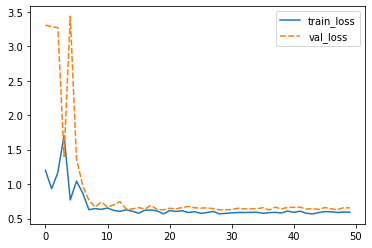

In [21]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet50_lrscheduler_wholenetwork')

E6)Train lastlayer, LR scheduler, 100 epochs, resnet50 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248

In [22]:
model_conv = torchvision.models.resnet50(pretrained=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.6397 Acc: 0.6393
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6393
val Loss: 0.7696 Acc: 0.6275
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6275

Epoch 1/499
----------
train Loss: 0.6021 Acc: 0.6598
train Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6598
val Loss: 0.7257 Acc: 0.6340
val Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6340

Epoch 2/499
----------
train Loss: 0.6305 Acc: 0.6803
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6803
val Loss: 0.7079 Acc: 0.6405
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6405

Epoch 3/499
----------
train Loss: 0.6219 Acc: 0.6230
train Rajat Best_Acc: 0.6405 Epoch_Acc: 0.6230
val Loss: 0.7222 Acc: 0.6471
val Rajat Best_Acc: 0.6405 Epoch_Acc: 0.6471

Epoch 4/499
----------
train Loss: 0.6404 Acc: 0.6721
train Rajat Best_Acc: 0.6471 Epoch_Acc: 0.6721
val Loss: 0.8001 Acc: 0.6797
val Rajat Best_Acc: 0.6471 Epoch_Acc: 0.6797

Epoch 5/499
----------
train Loss: 0.6138 Acc: 0.6475
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6475
val Loss: 0.7156 Ac

val Loss: 0.7313 Acc: 0.6667
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6667

Epoch 47/499
----------
train Loss: 0.5737 Acc: 0.7090
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.7090
val Loss: 0.6938 Acc: 0.6601
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6601

Epoch 48/499
----------
train Loss: 0.6001 Acc: 0.6639
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6639
val Loss: 0.7093 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 49/499
----------
train Loss: 0.5983 Acc: 0.6844
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6844
val Loss: 0.7271 Acc: 0.6340
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6340

Epoch 50/499
----------
train Loss: 0.6203 Acc: 0.6516
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6516
val Loss: 0.7247 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 51/499
----------
train Loss: 0.6067 Acc: 0.7090
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.7090
val Loss: 0.7082 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 52/499
----------
train Loss: 0.60

train Loss: 0.6223 Acc: 0.6516
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6516
val Loss: 0.6888 Acc: 0.6667
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6667

Epoch 94/499
----------
train Loss: 0.6046 Acc: 0.6762
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6762
val Loss: 0.7435 Acc: 0.6471
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6471

Epoch 95/499
----------
train Loss: 0.6077 Acc: 0.6557
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6557
val Loss: 0.7838 Acc: 0.6340
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6340

Epoch 96/499
----------
train Loss: 0.6099 Acc: 0.6926
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6926
val Loss: 0.7214 Acc: 0.6732
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6732

Epoch 97/499
----------
train Loss: 0.6025 Acc: 0.7172
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.7172
val Loss: 0.7188 Acc: 0.6601
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6601

Epoch 98/499
----------
train Loss: 0.6021 Acc: 0.6598
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6598
val Loss: 0.7054 Acc: 0.6536
val Raja

val Loss: 0.7222 Acc: 0.6536
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6536

Epoch 140/499
----------
train Loss: 0.6017 Acc: 0.6762
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6762
val Loss: 0.7526 Acc: 0.6536
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6536

Epoch 141/499
----------
train Loss: 0.5914 Acc: 0.6803
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6803
val Loss: 0.7456 Acc: 0.6144
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6144

Epoch 142/499
----------
train Loss: 0.5955 Acc: 0.6885
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6885
val Loss: 0.7038 Acc: 0.6405
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6405

Epoch 143/499
----------
train Loss: 0.5872 Acc: 0.7131
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.7131
val Loss: 0.7210 Acc: 0.6797
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6797

Epoch 144/499
----------
train Loss: 0.6437 Acc: 0.6148
train Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6148
val Loss: 0.7754 Acc: 0.6275
val Rajat Best_Acc: 0.6863 Epoch_Acc: 0.6275

Epoch 145/499
----------
train Loss

train Loss: 0.6189 Acc: 0.6598
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6598
val Loss: 0.7064 Acc: 0.6275
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6275

Epoch 187/499
----------
train Loss: 0.5909 Acc: 0.6721
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6721
val Loss: 0.7470 Acc: 0.6601
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6601

Epoch 188/499
----------
train Loss: 0.6032 Acc: 0.6803
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6803
val Loss: 0.7248 Acc: 0.6471
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6471

Epoch 189/499
----------
train Loss: 0.6253 Acc: 0.6598
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6598
val Loss: 0.7268 Acc: 0.6732
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6732

Epoch 190/499
----------
train Loss: 0.6191 Acc: 0.6598
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6598
val Loss: 0.7080 Acc: 0.6275
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6275

Epoch 191/499
----------
train Loss: 0.6381 Acc: 0.6475
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6475
val Loss: 0.7643 Acc: 0.6144
val

val Loss: 0.7215 Acc: 0.6667
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6667

Epoch 233/499
----------
train Loss: 0.6122 Acc: 0.6475
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6475
val Loss: 0.7115 Acc: 0.6471
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6471

Epoch 234/499
----------
train Loss: 0.6158 Acc: 0.6475
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6475
val Loss: 0.7485 Acc: 0.6601
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6601

Epoch 235/499
----------
train Loss: 0.5929 Acc: 0.7090
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.7090
val Loss: 0.6937 Acc: 0.6667
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6667

Epoch 236/499
----------
train Loss: 0.6417 Acc: 0.6680
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6680
val Loss: 0.7819 Acc: 0.6275
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6275

Epoch 237/499
----------
train Loss: 0.6355 Acc: 0.6598
train Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6598
val Loss: 0.7284 Acc: 0.6405
val Rajat Best_Acc: 0.6993 Epoch_Acc: 0.6405

Epoch 238/499
----------
train Loss

train Loss: 0.6214 Acc: 0.6475
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6475
val Loss: 0.6945 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 280/499
----------
train Loss: 0.5896 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.8012 Acc: 0.6078
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6078

Epoch 281/499
----------
train Loss: 0.5934 Acc: 0.7213
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7213
val Loss: 0.7589 Acc: 0.6209
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6209

Epoch 282/499
----------
train Loss: 0.6228 Acc: 0.6475
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6475
val Loss: 0.7331 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 283/499
----------
train Loss: 0.6147 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.6804 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 284/499
----------
train Loss: 0.6043 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.7102 Acc: 0.6275
val

val Loss: 0.7346 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 326/499
----------
train Loss: 0.5790 Acc: 0.6844
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6844
val Loss: 0.7119 Acc: 0.6863
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6863

Epoch 327/499
----------
train Loss: 0.6632 Acc: 0.6393
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6393
val Loss: 0.7646 Acc: 0.6209
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6209

Epoch 328/499
----------
train Loss: 0.6176 Acc: 0.6598
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6598
val Loss: 0.7080 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 329/499
----------
train Loss: 0.6248 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.7310 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 330/499
----------
train Loss: 0.6243 Acc: 0.6393
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6393
val Loss: 0.7047 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 331/499
----------
train Loss

train Loss: 0.6029 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.7181 Acc: 0.6340
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6340

Epoch 373/499
----------
train Loss: 0.6097 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.7292 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 374/499
----------
train Loss: 0.6187 Acc: 0.6393
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6393
val Loss: 0.7515 Acc: 0.6209
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6209

Epoch 375/499
----------
train Loss: 0.6114 Acc: 0.6721
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6721
val Loss: 0.7687 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 376/499
----------
train Loss: 0.6084 Acc: 0.6434
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6434
val Loss: 0.6864 Acc: 0.6340
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6340

Epoch 377/499
----------
train Loss: 0.6374 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.7449 Acc: 0.6340
val

val Loss: 0.7117 Acc: 0.6340
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6340

Epoch 419/499
----------
train Loss: 0.5947 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.7026 Acc: 0.6928
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6928

Epoch 420/499
----------
train Loss: 0.5998 Acc: 0.6598
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6598
val Loss: 0.6822 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 421/499
----------
train Loss: 0.5977 Acc: 0.6885
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6885
val Loss: 0.7114 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 422/499
----------
train Loss: 0.5713 Acc: 0.7049
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.7049
val Loss: 0.7220 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 423/499
----------
train Loss: 0.6017 Acc: 0.6475
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6475
val Loss: 0.7081 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 424/499
----------
train Loss

train Loss: 0.5873 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.7344 Acc: 0.6797
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6797

Epoch 466/499
----------
train Loss: 0.6030 Acc: 0.6352
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6352
val Loss: 0.7590 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 467/499
----------
train Loss: 0.6151 Acc: 0.6680
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6680
val Loss: 0.7599 Acc: 0.6667
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6667

Epoch 468/499
----------
train Loss: 0.6570 Acc: 0.6230
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6230
val Loss: 0.7350 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 469/499
----------
train Loss: 0.5955 Acc: 0.6762
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6762
val Loss: 0.7282 Acc: 0.6536
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6536

Epoch 470/499
----------
train Loss: 0.6167 Acc: 0.6639
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6639
val Loss: 0.7195 Acc: 0.6601
val

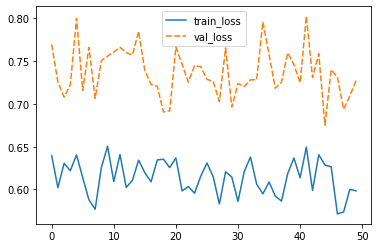

In [23]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet50_lrscheduler_lastlayer')

E7)Train WholeNetwork, LR scheduler, 100 epochs, resnet101
----------------------------------

Resnet101, train the whole network



Epoch 0/499
----------
train Loss: 0.8204 Acc: 0.4877
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.4877
val Loss: 1.0312 Acc: 0.5425
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5425

Epoch 1/499
----------
train Loss: 0.8999 Acc: 0.5738
train Rajat Best_Acc: 0.5425 Epoch_Acc: 0.5738
val Loss: 4.1860 Acc: 0.5556
val Rajat Best_Acc: 0.5425 Epoch_Acc: 0.5556

Epoch 2/499
----------
train Loss: 1.0343 Acc: 0.5205
train Rajat Best_Acc: 0.5556 Epoch_Acc: 0.5205
val Loss: 2.9479 Acc: 0.5425
val Rajat Best_Acc: 0.5556 Epoch_Acc: 0.5425

Epoch 3/499
----------
train Loss: 0.9428 Acc: 0.5820
train Rajat Best_Acc: 0.5556 Epoch_Acc: 0.5820
val Loss: 0.9940 Acc: 0.6013
val Rajat Best_Acc: 0.5556 Epoch_Acc: 0.6013

Epoch 4/499
----------
train Loss: 1.0665 Acc: 0.5205
train Rajat Best_Acc: 0.6013 Epoch_Acc: 0.5205
val Loss: 1.5226 Acc: 0.5686
val Rajat Best_Acc: 0.6013 Epoch_Acc: 0.5686

Epoch 5/499
----------
train Loss: 1.4038 Acc: 0.4918
train Rajat Best_Acc: 0.6013 Epoch_Acc: 0.4918
val Loss: 1.6001 Ac

val Loss: 0.7270 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 47/499
----------
train Loss: 0.6250 Acc: 0.6557
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6557
val Loss: 0.7340 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 48/499
----------
train Loss: 0.6670 Acc: 0.5697
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5697
val Loss: 0.7479 Acc: 0.5490
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5490

Epoch 49/499
----------
train Loss: 0.5976 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7135 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 50/499
----------
train Loss: 0.6087 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7253 Acc: 0.5882
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5882

Epoch 51/499
----------
train Loss: 0.6240 Acc: 0.6352
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6352
val Loss: 0.7676 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 52/499
----------
train Loss: 0.64

train Loss: 0.6373 Acc: 0.6557
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6557
val Loss: 0.7546 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 94/499
----------
train Loss: 0.6355 Acc: 0.6311
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6311
val Loss: 0.7577 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 95/499
----------
train Loss: 0.6255 Acc: 0.6352
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6352
val Loss: 0.7527 Acc: 0.5752
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5752

Epoch 96/499
----------
train Loss: 0.6273 Acc: 0.6516
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6516
val Loss: 0.7177 Acc: 0.5359
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5359

Epoch 97/499
----------
train Loss: 0.5971 Acc: 0.6721
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6721
val Loss: 0.7605 Acc: 0.5752
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5752

Epoch 98/499
----------
train Loss: 0.6180 Acc: 0.6557
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6557
val Loss: 0.6944 Acc: 0.5621
val Raja

val Loss: 0.7253 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 140/499
----------
train Loss: 0.6119 Acc: 0.6680
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6680
val Loss: 0.7309 Acc: 0.5817
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5817

Epoch 141/499
----------
train Loss: 0.6440 Acc: 0.6148
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6148
val Loss: 0.7331 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 142/499
----------
train Loss: 0.6282 Acc: 0.6393
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6393
val Loss: 0.7907 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 143/499
----------
train Loss: 0.6315 Acc: 0.6639
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6639
val Loss: 0.7101 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 144/499
----------
train Loss: 0.6007 Acc: 0.6434
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6434
val Loss: 0.7347 Acc: 0.5752
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5752

Epoch 145/499
----------
train Loss

train Loss: 0.6294 Acc: 0.6189
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6189
val Loss: 0.7282 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 187/499
----------
train Loss: 0.6334 Acc: 0.6639
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6639
val Loss: 0.7470 Acc: 0.5882
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5882

Epoch 188/499
----------
train Loss: 0.6078 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.8209 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 189/499
----------
train Loss: 0.6047 Acc: 0.6680
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6680
val Loss: 0.7274 Acc: 0.5490
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5490

Epoch 190/499
----------
train Loss: 0.6246 Acc: 0.6721
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6721
val Loss: 0.7201 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 191/499
----------
train Loss: 0.6063 Acc: 0.6762
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6762
val Loss: 0.7195 Acc: 0.5948
val

val Loss: 0.7260 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 233/499
----------
train Loss: 0.6433 Acc: 0.6680
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6680
val Loss: 0.8218 Acc: 0.5817
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5817

Epoch 234/499
----------
train Loss: 0.6365 Acc: 0.5902
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5902
val Loss: 0.7295 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 235/499
----------
train Loss: 0.6102 Acc: 0.6967
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6967
val Loss: 0.7172 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 236/499
----------
train Loss: 0.6125 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7513 Acc: 0.5425
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5425

Epoch 237/499
----------
train Loss: 0.6137 Acc: 0.6639
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6639
val Loss: 0.7690 Acc: 0.5294
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5294

Epoch 238/499
----------
train Loss

train Loss: 0.6130 Acc: 0.6721
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6721
val Loss: 0.7632 Acc: 0.5817
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5817

Epoch 280/499
----------
train Loss: 0.6119 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7743 Acc: 0.5882
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5882

Epoch 281/499
----------
train Loss: 0.6630 Acc: 0.6066
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6066
val Loss: 0.7534 Acc: 0.5948
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5948

Epoch 282/499
----------
train Loss: 0.6455 Acc: 0.6230
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6230
val Loss: 0.7800 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 283/499
----------
train Loss: 0.6431 Acc: 0.6352
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6352
val Loss: 0.7174 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 284/499
----------
train Loss: 0.6237 Acc: 0.6516
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6516
val Loss: 0.7517 Acc: 0.5556
val

val Loss: 0.7789 Acc: 0.5817
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5817

Epoch 326/499
----------
train Loss: 0.5948 Acc: 0.6844
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6844
val Loss: 0.7711 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 327/499
----------
train Loss: 0.6357 Acc: 0.6066
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6066
val Loss: 0.7006 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 328/499
----------
train Loss: 0.6358 Acc: 0.6148
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6148
val Loss: 0.7452 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 329/499
----------
train Loss: 0.6148 Acc: 0.6393
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6393
val Loss: 0.7416 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 330/499
----------
train Loss: 0.6442 Acc: 0.5779
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5779
val Loss: 0.7214 Acc: 0.5359
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5359

Epoch 331/499
----------
train Loss

train Loss: 0.6303 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7318 Acc: 0.5490
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5490

Epoch 373/499
----------
train Loss: 0.6519 Acc: 0.6189
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6189
val Loss: 0.7633 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 374/499
----------
train Loss: 0.6066 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7602 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 375/499
----------
train Loss: 0.6221 Acc: 0.6230
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6230
val Loss: 0.7209 Acc: 0.5556
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5556

Epoch 376/499
----------
train Loss: 0.6472 Acc: 0.6189
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6189
val Loss: 0.7897 Acc: 0.5686
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5686

Epoch 377/499
----------
train Loss: 0.6733 Acc: 0.5697
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5697
val Loss: 0.7970 Acc: 0.5752
val

val Loss: 0.8097 Acc: 0.5490
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5490

Epoch 419/499
----------
train Loss: 0.6169 Acc: 0.6434
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6434
val Loss: 0.7348 Acc: 0.5817
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5817

Epoch 420/499
----------
train Loss: 0.6349 Acc: 0.6393
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6393
val Loss: 0.7483 Acc: 0.5752
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5752

Epoch 421/499
----------
train Loss: 0.6589 Acc: 0.6025
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6025
val Loss: 0.7436 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 422/499
----------
train Loss: 0.6368 Acc: 0.6475
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6475
val Loss: 0.7681 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 423/499
----------
train Loss: 0.6188 Acc: 0.6311
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6311
val Loss: 0.7336 Acc: 0.5490
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5490

Epoch 424/499
----------
train Loss

train Loss: 0.6497 Acc: 0.6311
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6311
val Loss: 0.7480 Acc: 0.5425
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5425

Epoch 466/499
----------
train Loss: 0.6345 Acc: 0.6270
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6270
val Loss: 0.7399 Acc: 0.5294
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5294

Epoch 467/499
----------
train Loss: 0.5914 Acc: 0.6762
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6762
val Loss: 0.7640 Acc: 0.5621
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5621

Epoch 468/499
----------
train Loss: 0.6174 Acc: 0.6434
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6434
val Loss: 0.8107 Acc: 0.5359
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5359

Epoch 469/499
----------
train Loss: 0.6413 Acc: 0.6434
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.6434
val Loss: 0.7670 Acc: 0.5425
val Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5425

Epoch 470/499
----------
train Loss: 0.6373 Acc: 0.5943
train Rajat Best_Acc: 0.6340 Epoch_Acc: 0.5943
val Loss: 0.7948 Acc: 0.5686
val

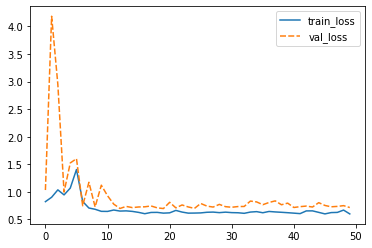

In [24]:
model_ft = models.resnet101(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet101_lrscheduler_wholenetwork')

Epoch 0/499
----------
train Loss: 0.6223 Acc: 0.6680
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6680
val Loss: 0.6930 Acc: 0.6144
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6144

Epoch 1/499
----------
train Loss: 0.6784 Acc: 0.5738
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5738
val Loss: 0.7018 Acc: 0.5948
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5948

Epoch 2/499
----------
train Loss: 0.6640 Acc: 0.5943
train Rajat Best_Acc: 0.6144 Epoch_Acc: 0.5943
val Loss: 0.7099 Acc: 0.6275
val Rajat Best_Acc: 0.6144 Epoch_Acc: 0.6275

Epoch 3/499
----------
train Loss: 0.7092 Acc: 0.6148
train Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6148
val Loss: 0.7566 Acc: 0.6209
val Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6209

Epoch 4/499
----------
train Loss: 0.6660 Acc: 0.6598
train Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6598
val Loss: 0.7230 Acc: 0.6078
val Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6078

Epoch 5/499
----------
train Loss: 0.6144 Acc: 0.6598
train Rajat Best_Acc: 0.6275 Epoch_Acc: 0.6598
val Loss: 0.7120 Ac

val Loss: 0.7284 Acc: 0.6471
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6471

Epoch 47/499
----------
train Loss: 0.6533 Acc: 0.6270
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6270
val Loss: 0.6961 Acc: 0.6144
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6144

Epoch 48/499
----------
train Loss: 0.6635 Acc: 0.6230
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6230
val Loss: 0.7118 Acc: 0.6209
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6209

Epoch 49/499
----------
train Loss: 0.6769 Acc: 0.5902
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.5902
val Loss: 0.7260 Acc: 0.6405
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6405

Epoch 50/499
----------
train Loss: 0.6598 Acc: 0.5943
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.5943
val Loss: 0.7239 Acc: 0.6144
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6144

Epoch 51/499
----------
train Loss: 0.6315 Acc: 0.6680
train Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6680
val Loss: 0.6918 Acc: 0.6275
val Rajat Best_Acc: 0.6601 Epoch_Acc: 0.6275

Epoch 52/499
----------
train Loss: 0.62

train Loss: 0.6536 Acc: 0.6475
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6475
val Loss: 0.7557 Acc: 0.6471
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6471

Epoch 94/499
----------
train Loss: 0.6598 Acc: 0.6066
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6066
val Loss: 0.7435 Acc: 0.6471
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6471

Epoch 95/499
----------
train Loss: 0.6553 Acc: 0.6434
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6434
val Loss: 0.7238 Acc: 0.6536
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6536

Epoch 96/499
----------
train Loss: 0.6467 Acc: 0.6557
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6557
val Loss: 0.7592 Acc: 0.6209
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6209

Epoch 97/499
----------
train Loss: 0.6423 Acc: 0.6311
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6311
val Loss: 0.7439 Acc: 0.6340
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6340

Epoch 98/499
----------
train Loss: 0.6610 Acc: 0.5943
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5943
val Loss: 0.7191 Acc: 0.6275
val Raja

val Loss: 0.7223 Acc: 0.6144
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6144

Epoch 140/499
----------
train Loss: 0.6901 Acc: 0.6107
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6107
val Loss: 0.7227 Acc: 0.6144
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6144

Epoch 141/499
----------
train Loss: 0.6887 Acc: 0.6230
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6230
val Loss: 0.7077 Acc: 0.6471
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6471

Epoch 142/499
----------
train Loss: 0.6719 Acc: 0.6107
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6107
val Loss: 0.7241 Acc: 0.6209
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6209

Epoch 143/499
----------
train Loss: 0.6571 Acc: 0.6434
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6434
val Loss: 0.7209 Acc: 0.6078
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6078

Epoch 144/499
----------
train Loss: 0.6355 Acc: 0.6230
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6230
val Loss: 0.7177 Acc: 0.5948
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5948

Epoch 145/499
----------
train Loss

train Loss: 0.6128 Acc: 0.6639
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6639
val Loss: 0.7098 Acc: 0.6275
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6275

Epoch 187/499
----------
train Loss: 0.6470 Acc: 0.6393
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6393
val Loss: 0.7579 Acc: 0.6405
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6405

Epoch 188/499
----------
train Loss: 0.6692 Acc: 0.6311
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6311
val Loss: 0.7459 Acc: 0.6340
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6340

Epoch 189/499
----------
train Loss: 0.6243 Acc: 0.6475
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6475
val Loss: 0.7100 Acc: 0.6209
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6209

Epoch 190/499
----------
train Loss: 0.6602 Acc: 0.6352
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6352
val Loss: 0.7072 Acc: 0.6275
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6275

Epoch 191/499
----------
train Loss: 0.6571 Acc: 0.5820
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5820
val Loss: 0.6993 Acc: 0.6275
val

val Loss: 0.7433 Acc: 0.6601
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6601

Epoch 233/499
----------
train Loss: 0.6404 Acc: 0.6393
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6393
val Loss: 0.7185 Acc: 0.6340
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6340

Epoch 234/499
----------
train Loss: 0.6747 Acc: 0.5902
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5902
val Loss: 0.7107 Acc: 0.6275
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6275

Epoch 235/499
----------
train Loss: 0.6607 Acc: 0.5902
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5902
val Loss: 0.7330 Acc: 0.6405
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6405

Epoch 236/499
----------
train Loss: 0.6516 Acc: 0.6230
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6230
val Loss: 0.7254 Acc: 0.6275
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6275

Epoch 237/499
----------
train Loss: 0.7103 Acc: 0.5943
train Rajat Best_Acc: 0.6732 Epoch_Acc: 0.5943
val Loss: 0.7382 Acc: 0.6471
val Rajat Best_Acc: 0.6732 Epoch_Acc: 0.6471

Epoch 238/499
----------
train Loss

train Loss: 0.6549 Acc: 0.6434
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6434
val Loss: 0.7115 Acc: 0.6471
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6471

Epoch 280/499
----------
train Loss: 0.6913 Acc: 0.6230
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6230
val Loss: 0.7154 Acc: 0.6013
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6013

Epoch 281/499
----------
train Loss: 0.6461 Acc: 0.6352
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6352
val Loss: 0.6895 Acc: 0.6471
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6471

Epoch 282/499
----------
train Loss: 0.6299 Acc: 0.6434
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6434
val Loss: 0.7437 Acc: 0.6471
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6471

Epoch 283/499
----------
train Loss: 0.6879 Acc: 0.6230
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6230
val Loss: 0.7598 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 284/499
----------
train Loss: 0.6917 Acc: 0.5697
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.5697
val Loss: 0.7541 Acc: 0.6340
val

val Loss: 0.7333 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 326/499
----------
train Loss: 0.7005 Acc: 0.5984
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.5984
val Loss: 0.7479 Acc: 0.6340
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6340

Epoch 327/499
----------
train Loss: 0.6357 Acc: 0.6516
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6516
val Loss: 0.7607 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 328/499
----------
train Loss: 0.6325 Acc: 0.6270
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6270
val Loss: 0.7272 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 329/499
----------
train Loss: 0.6956 Acc: 0.6230
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6230
val Loss: 0.7213 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 330/499
----------
train Loss: 0.6447 Acc: 0.6393
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6393
val Loss: 0.7053 Acc: 0.6209
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6209

Epoch 331/499
----------
train Loss

train Loss: 0.6125 Acc: 0.6393
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6393
val Loss: 0.7076 Acc: 0.6275
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6275

Epoch 373/499
----------
train Loss: 0.6881 Acc: 0.6189
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6189
val Loss: 0.7211 Acc: 0.6209
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6209

Epoch 374/499
----------
train Loss: 0.6642 Acc: 0.6434
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6434
val Loss: 0.7291 Acc: 0.6275
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6275

Epoch 375/499
----------
train Loss: 0.6563 Acc: 0.6680
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6680
val Loss: 0.7266 Acc: 0.6536
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6536

Epoch 376/499
----------
train Loss: 0.6410 Acc: 0.6557
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6557
val Loss: 0.7282 Acc: 0.6144
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6144

Epoch 377/499
----------
train Loss: 0.6474 Acc: 0.6352
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6352
val Loss: 0.7037 Acc: 0.6209
val

val Loss: 0.7374 Acc: 0.6340
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6340

Epoch 419/499
----------
train Loss: 0.6955 Acc: 0.5820
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.5820
val Loss: 0.7294 Acc: 0.6144
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6144

Epoch 420/499
----------
train Loss: 0.6688 Acc: 0.6066
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6066
val Loss: 0.7137 Acc: 0.6340
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6340

Epoch 421/499
----------
train Loss: 0.6539 Acc: 0.6148
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6148
val Loss: 0.7383 Acc: 0.6536
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6536

Epoch 422/499
----------
train Loss: 0.6902 Acc: 0.5984
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.5984
val Loss: 0.7459 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 423/499
----------
train Loss: 0.6654 Acc: 0.6107
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6107
val Loss: 0.7300 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 424/499
----------
train Loss

train Loss: 0.6794 Acc: 0.6762
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6762
val Loss: 0.7182 Acc: 0.6275
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6275

Epoch 466/499
----------
train Loss: 0.6493 Acc: 0.6270
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6270
val Loss: 0.7075 Acc: 0.6601
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6601

Epoch 467/499
----------
train Loss: 0.6927 Acc: 0.6270
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6270
val Loss: 0.7048 Acc: 0.6405
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6405

Epoch 468/499
----------
train Loss: 0.6596 Acc: 0.6434
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6434
val Loss: 0.7077 Acc: 0.6078
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6078

Epoch 469/499
----------
train Loss: 0.6103 Acc: 0.6721
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6721
val Loss: 0.6815 Acc: 0.6209
val Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6209

Epoch 470/499
----------
train Loss: 0.6535 Acc: 0.6230
train Rajat Best_Acc: 0.6797 Epoch_Acc: 0.6230
val Loss: 0.7236 Acc: 0.6601
val

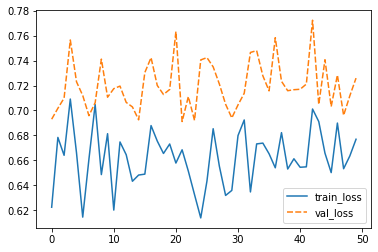

In [25]:
model_ft = models.resnet101(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet101_lrscheduler_wholenetwork')

In [9]:
model_ft = models.resnet152(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'without-pretrained-resnet152_lrscheduler_wholenetwork')

Epoch 0/499
----------
train Loss: 0.9353 Acc: 0.5369
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5369
val Loss: 22.8180 Acc: 0.5686
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.5686

Epoch 1/499
----------
train Loss: 0.9177 Acc: 0.5328
train Rajat Best_Acc: 0.5686 Epoch_Acc: 0.5328
val Loss: 2.2513 Acc: 0.5425
val Rajat Best_Acc: 0.5686 Epoch_Acc: 0.5425

Epoch 2/499
----------
train Loss: 0.9070 Acc: 0.5246
train Rajat Best_Acc: 0.5686 Epoch_Acc: 0.5246
val Loss: 4.6482 Acc: 0.4575
val Rajat Best_Acc: 0.5686 Epoch_Acc: 0.4575

Epoch 3/499
----------
train Loss: 0.8547 Acc: 0.5615
train Rajat Best_Acc: 0.5686 Epoch_Acc: 0.5615
val Loss: 1.2681 Acc: 0.4575
val Rajat Best_Acc: 0.5686 Epoch_Acc: 0.4575

Epoch 4/499
----------
train Loss: 1.0515 Acc: 0.5205
train Rajat Best_Acc: 0.5686 Epoch_Acc: 0.5205
val Loss: 0.8328 Acc: 0.6209
val Rajat Best_Acc: 0.5686 Epoch_Acc: 0.6209

Epoch 5/499
----------
train Loss: 0.8311 Acc: 0.5533
train Rajat Best_Acc: 0.6209 Epoch_Acc: 0.5533
val Loss: 1.6964 A

val Loss: 0.6050 Acc: 0.6601
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6601

Epoch 47/499
----------
train Loss: 0.6500 Acc: 0.6189
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6189
val Loss: 0.5885 Acc: 0.6405
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6405

Epoch 48/499
----------
train Loss: 0.6278 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6010 Acc: 0.6275
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6275

Epoch 49/499
----------
train Loss: 0.6373 Acc: 0.6557
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6557
val Loss: 0.6049 Acc: 0.6732
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6732

Epoch 50/499
----------
train Loss: 0.6547 Acc: 0.6516
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6516
val Loss: 0.6210 Acc: 0.5752
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.5752

Epoch 51/499
----------
train Loss: 0.6642 Acc: 0.5697
train Rajat Best_Acc: 0.7059 Epoch_Acc: 0.5697
val Loss: 0.5962 Acc: 0.6471
val Rajat Best_Acc: 0.7059 Epoch_Acc: 0.6471

Epoch 52/499
----------
train Loss: 0.62

train Loss: 0.6406 Acc: 0.6189
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6189
val Loss: 0.6000 Acc: 0.6601
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6601

Epoch 94/499
----------
train Loss: 0.6313 Acc: 0.6844
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6844
val Loss: 0.6040 Acc: 0.6405
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6405

Epoch 95/499
----------
train Loss: 0.6444 Acc: 0.6189
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6189
val Loss: 0.6226 Acc: 0.6275
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6275

Epoch 96/499
----------
train Loss: 0.6403 Acc: 0.6475
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6475
val Loss: 0.6159 Acc: 0.6405
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6405

Epoch 97/499
----------
train Loss: 0.6300 Acc: 0.6311
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6311
val Loss: 0.6023 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 98/499
----------
train Loss: 0.6484 Acc: 0.6393
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6393
val Loss: 0.5990 Acc: 0.6209
val Raja

val Loss: 0.6030 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 140/499
----------
train Loss: 0.6596 Acc: 0.6270
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6270
val Loss: 0.6048 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 141/499
----------
train Loss: 0.6434 Acc: 0.6393
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6393
val Loss: 0.6253 Acc: 0.6275
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6275

Epoch 142/499
----------
train Loss: 0.6445 Acc: 0.6189
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6189
val Loss: 0.6150 Acc: 0.6144
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6144

Epoch 143/499
----------
train Loss: 0.6434 Acc: 0.5861
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.5861
val Loss: 0.6059 Acc: 0.6144
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6144

Epoch 144/499
----------
train Loss: 0.6487 Acc: 0.6270
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6270
val Loss: 0.5965 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 145/499
----------
train Loss

train Loss: 0.6508 Acc: 0.6352
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6352
val Loss: 0.6181 Acc: 0.5621
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.5621

Epoch 187/499
----------
train Loss: 0.6340 Acc: 0.6434
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6434
val Loss: 0.6095 Acc: 0.6340
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6340

Epoch 188/499
----------
train Loss: 0.6323 Acc: 0.6270
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6270
val Loss: 0.6063 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 189/499
----------
train Loss: 0.6343 Acc: 0.6148
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6148
val Loss: 0.6057 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 190/499
----------
train Loss: 0.6397 Acc: 0.6516
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6516
val Loss: 0.6120 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 191/499
----------
train Loss: 0.6485 Acc: 0.6352
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6352
val Loss: 0.6022 Acc: 0.6732
val

val Loss: 0.5877 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 233/499
----------
train Loss: 0.6571 Acc: 0.5902
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.5902
val Loss: 0.5963 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 234/499
----------
train Loss: 0.6481 Acc: 0.6230
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6230
val Loss: 0.6253 Acc: 0.6405
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6405

Epoch 235/499
----------
train Loss: 0.6482 Acc: 0.6270
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6270
val Loss: 0.5941 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 236/499
----------
train Loss: 0.6506 Acc: 0.6148
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6148
val Loss: 0.6171 Acc: 0.6013
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6013

Epoch 237/499
----------
train Loss: 0.6382 Acc: 0.6352
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6352
val Loss: 0.6070 Acc: 0.6601
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6601

Epoch 238/499
----------
train Loss

train Loss: 0.6417 Acc: 0.6598
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6598
val Loss: 0.6055 Acc: 0.6405
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6405

Epoch 280/499
----------
train Loss: 0.6388 Acc: 0.6639
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6639
val Loss: 0.6071 Acc: 0.6536
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6536

Epoch 281/499
----------
train Loss: 0.6439 Acc: 0.6311
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6311
val Loss: 0.6088 Acc: 0.6144
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6144

Epoch 282/499
----------
train Loss: 0.6498 Acc: 0.5984
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.5984
val Loss: 0.5945 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 283/499
----------
train Loss: 0.6424 Acc: 0.6434
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6434
val Loss: 0.6121 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 284/499
----------
train Loss: 0.6390 Acc: 0.6475
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6475
val Loss: 0.5967 Acc: 0.6732
val

val Loss: 0.6146 Acc: 0.6275
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6275

Epoch 326/499
----------
train Loss: 0.6434 Acc: 0.6107
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6107
val Loss: 0.5992 Acc: 0.6797
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6797

Epoch 327/499
----------
train Loss: 0.6401 Acc: 0.6025
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6025
val Loss: 0.6098 Acc: 0.6732
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6732

Epoch 328/499
----------
train Loss: 0.6403 Acc: 0.6066
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6066
val Loss: 0.6059 Acc: 0.6275
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6275

Epoch 329/499
----------
train Loss: 0.6460 Acc: 0.6434
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6434
val Loss: 0.6164 Acc: 0.6013
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6013

Epoch 330/499
----------
train Loss: 0.6283 Acc: 0.6557
train Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6557
val Loss: 0.5961 Acc: 0.6667
val Rajat Best_Acc: 0.7190 Epoch_Acc: 0.6667

Epoch 331/499
----------
train Loss

KeyboardInterrupt: 